In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sn

# Leitura dos resultados

In [93]:
results_df = pd.DataFrame(columns = ['Granularity',
                                     'True_Positive_Rate_Mean', 'True_Positive_Rate_Std',
                                     'False_Positive_Rate_Mean', 'False_Positive_Rate_Std',
                                     'True_Positive_Mean', 'True_Positive_Std',
                                     'True_Negative_Mean', 'True_Negative_Std',
                                     'False_Positive_Mean', 'False_Positive_Std',
                                     'False_Negative_Mean', 'False_Negative_Std',
                                     'N_Groups_Mean', 'N_Groups_Std',
                                     'Execution_Time_Mean', 'Execution_Time_Std'])


list_gra = [6,10,14,16]

iterations = 4

for i in list_gra:
    df = pd.DataFrame(columns = ['Granularity',
                                'True_Positive',
                                'True_Negative',
                                'False_Positive',
                                'False_Negative',
                                'N_Groups',
                                'Execution_Time'])
    
    for j in range(iterations):
        df_aux = pd.read_csv("results/detection_info_raw_{}_{}.csv".format(i,j))
        df_aux2 = pd.read_csv("results/performance_info_raw_{}_{}.csv".format(i,j))
        
        
        df_aux["Execution_Time"] = df_aux2["Time_Elapsed"]
        
        tp = df_aux['True_Positive']
        tn = df_aux['True_Negative']
        fp = df_aux['False_Positive']
        fn = df_aux['False_Negative']

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        df_aux["True_Positive_Rate"] = tpr*100
        df_aux["False_Positive_Rate"] = fpr*100
        
        df = pd.concat([df, df_aux])
    
    df = df.reset_index()
    df = df.drop('index',1)
    
    df["Time_s"] = df["Execution_Time"].apply(lambda x: datetime.strptime(x,"%H:%M:%S.%f").time())
    for k in range(df.shape[0]):
        df.loc[k,'Time_s'] = ((df.loc[k,'Time_s'].hour*60 + 
                               df.loc[k,'Time_s'].minute)*60 + 
                                   df.loc[k,'Time_s'].second) + df.loc[k,'Time_s'].microsecond/1000000
    
    
    
    results_dict = {'Granularity':i,
                    'True_Positive_Rate_Mean': df['True_Positive_Rate'].mean(),
                    'True_Positive_Rate_Std': df['True_Positive_Rate'].std(),
                    'False_Positive_Rate_Mean': df['False_Positive_Rate'].mean(),
                    'False_Positive_Rate_Std': df['False_Positive_Rate'].std(),
                    'True_Positive_Mean': df['True_Positive'].mean(), 
                    'True_Positive_Std': df['True_Positive'].std(),
                    'True_Negative_Mean': df['True_Negative'].mean(), 
                    'True_Negative_Std': df['True_Negative'].std(),
                    'False_Positive_Mean': df['False_Positive'].mean(), 
                    'False_Positive_Std': df['False_Positive'].std(),
                    'False_Negative_Mean': df['False_Negative'].mean(), 
                    'False_Negative_Std': df['False_Negative'].std(),
                    'N_Groups_Mean': df['N_Groups'].mean(), 
                    'N_Groups_Std': df['N_Groups'].std(),
                    'Execution_Time_Mean': df['Time_s'].mean(), 
                    'Execution_Time_Std': df['Time_s'].std()}
    
    results_df = results_df.append(results_dict, ignore_index=True)

df = results_df
df.to_csv('results/results_df.csv')

In [94]:
df

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,N_Groups_Mean,N_Groups_Std,Execution_Time_Mean,Execution_Time_Std
0,6.0,NaN,NaN,12.857143,0.0,0.0,0.0,61.0,0.0,9.0,0.0,0.0,0.0,150.0,0.0,6.178441,0.027438
1,10.0,NaN,NaN,51.428571,0.0,0.0,0.0,34.0,0.0,36.0,0.0,0.0,0.0,473.0,0.0,8.234076,0.706869
2,14.0,NaN,NaN,80.000000,0.0,0.0,0.0,14.0,0.0,56.0,0.0,0.0,0.0,619.0,0.0,8.552676,0.305244
3,16.0,NaN,NaN,87.142857,0.0,0.0,0.0,9.0,0.0,61.0,0.0,0.0,0.0,649.0,0.0,8.677862,0.171256


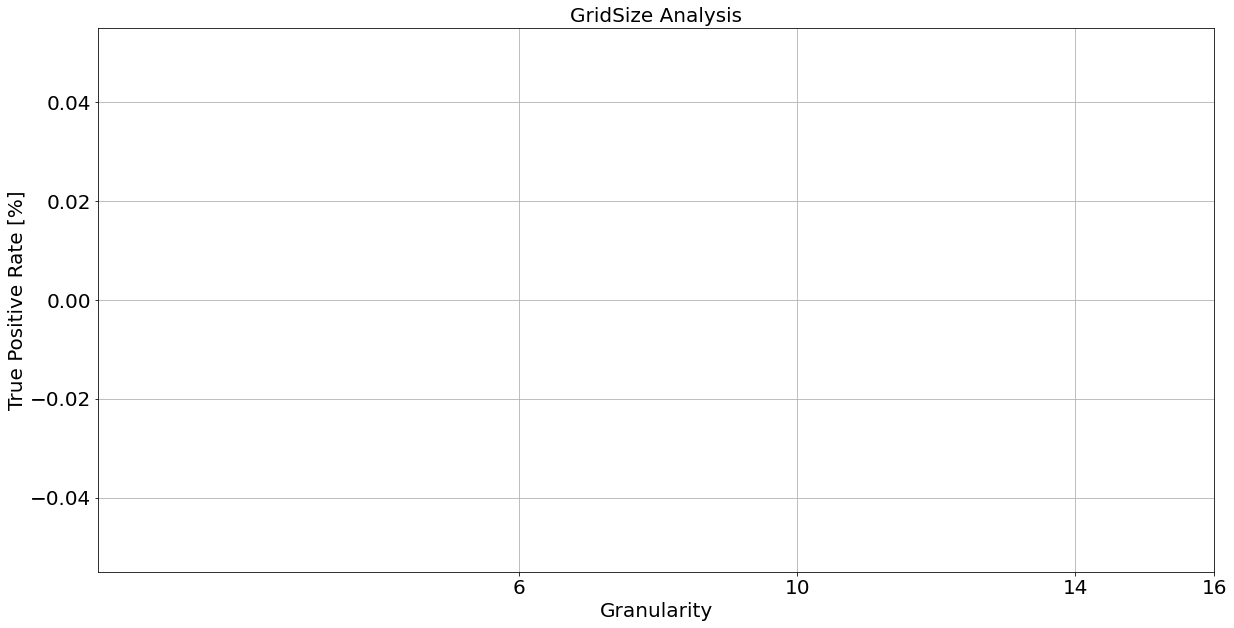

In [95]:
x = np.array(list_gra)

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['True_Positive_Rate_Mean'], width=0.4, color='b', align='center')


plt.plot([x,x], [df['True_Positive_Rate_Mean'] - df['True_Positive_Rate_Std'], 
                     df['True_Positive_Rate_Mean'] + df['True_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('True Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/True_Positive_Rate.png', bbox_inches='tight')
plt.show()

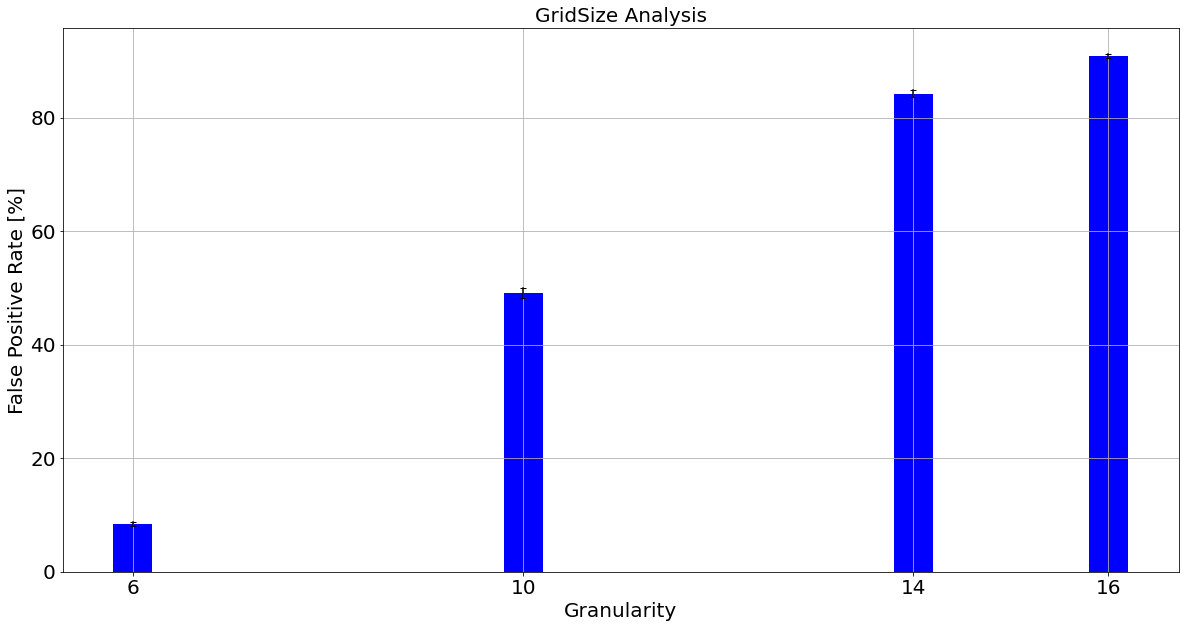

In [86]:
x = np.array(list_gra)

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['False_Positive_Rate_Mean'], width=0.4, color='b', align='center')


plt.plot([x,x], [df['False_Positive_Rate_Mean'] - df['False_Positive_Rate_Std'], 
                     df['False_Positive_Rate_Mean'] + df['False_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('False Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)


# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/False_Positive_Rate.png', bbox_inches='tight')
plt.show()

# Tempo de Execução

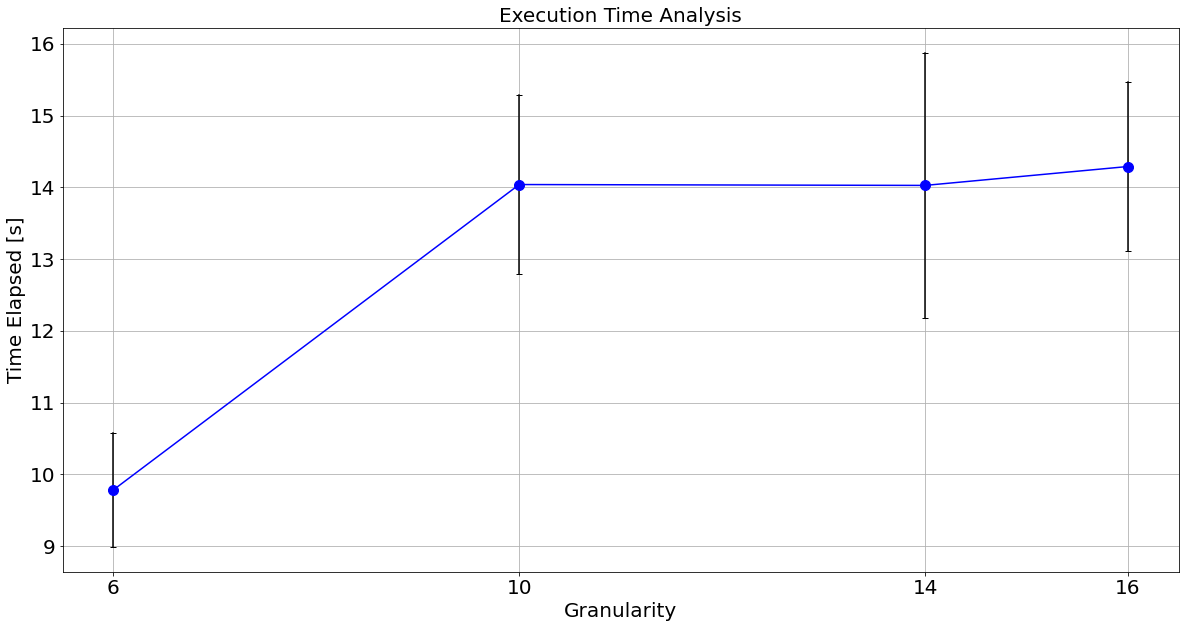

In [87]:
plt.figure(figsize=(20,10))
ax = plt.subplot()



ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Execution Time Analysis', fontsize=20)
ax.set_ylabel('Time Elapsed [s]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

ax.set_xticks(x)

plt.plot([x,x], [df['Execution_Time_Mean'] - df['Execution_Time_Std'], 
                     df['Execution_Time_Mean'] + df['Execution_Time_Std']], 'k_-')

plt.plot(df['Granularity'], df['Execution_Time_Mean'], 'b.-', markersize=20)
plt.grid()

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'r.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='r')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('results/Execution_time_2.png', bbox_inches='tight')
plt.show()

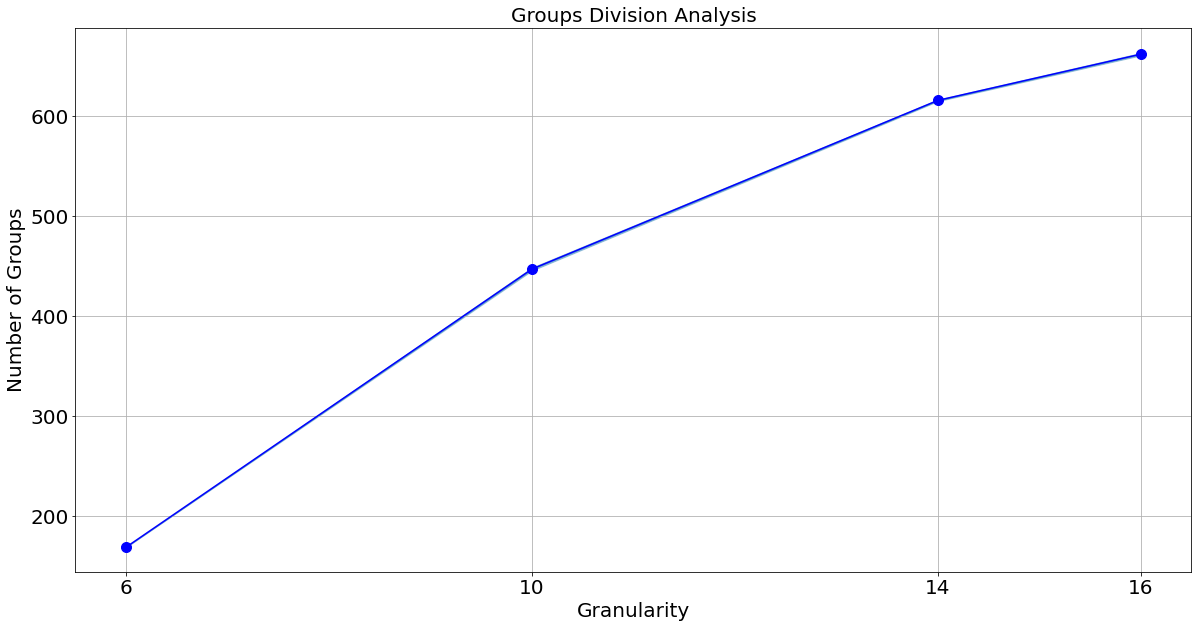

In [88]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

plt.plot(df['Granularity'], df['N_Groups_Mean'], 'b.-', markersize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Groups Division Analysis', fontsize=20)
ax.set_ylabel('Number of Groups', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

palette = sn.color_palette()[0]

# Plot da sombra entre a media e o maximo e minimo instantaneo
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']+df['N_Groups_Std'], alpha=.4, color=palette)
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']-df['N_Groups_Std'], alpha=.4, color=palette)

ax.set_xticks(x)

plt.grid()

plt.savefig('results/Number_of_Groups.png', bbox_inches='tight')
plt.show()

# ROC

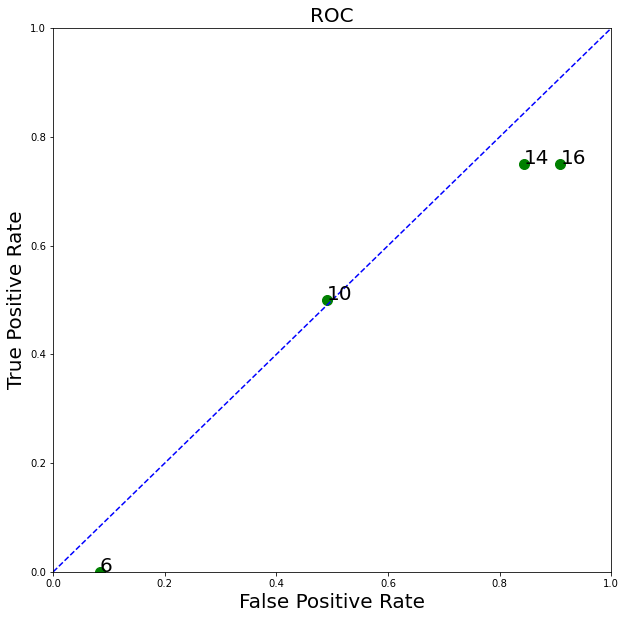

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df['False_Positive_Rate_Mean']/100, df['True_Positive_Rate_Mean']/100, c='g', s=100)
for i, txt in enumerate(x):
    ax.annotate(txt, (df['False_Positive_Rate_Mean'][i]/100, df['True_Positive_Rate_Mean'][i]/100), fontsize=20)    

ax.set_title('ROC', fontsize=20)
ax.plot([0, 1], [0, 1],'b--')    
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.savefig('results/ROC_2.png', bbox_inches='tight')

plt.show()

In [90]:
df[df['Granularity'] == 10]

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,N_Groups_Mean,N_Groups_Std,Execution_Time_Mean,Execution_Time_Std
1,10.0,50.0,57.735027,49.107143,0.89879,0.5,0.57735,71.25,1.258306,68.75,1.258306,0.5,0.57735,447.25,1.5,14.039345,1.251201


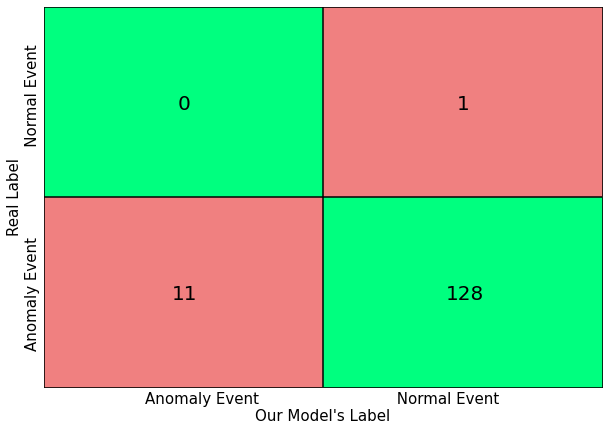

In [91]:
gra = 6


matrix = [ int(df[df['Granularity'] == gra]["True_Positive_Mean"]),  
           int(df[df['Granularity'] == gra]["False_Negative_Mean"]),
           int(df[df['Granularity'] == gra]["False_Positive_Mean"]), 
           int(df[df['Granularity'] == gra]["True_Negative_Mean"])]

fig = plt.figure(figsize=[10,7])
        
y_label = ['Anomaly Event', 'Normal Event']
x_label = ['Anomaly Event', 'Normal Event']


plt.plot([0,2],[1,1], color='k')
plt.plot([1,1],[0,2], color='k')


plt.fill_between([0,1],[1,1],[2,2], color='springgreen')
plt.fill_between([1,2],[1,1],[2,2], color='lightcoral')
plt.fill_between([0,1],[0,0],[1,1], color='lightcoral')
plt.fill_between([1,2],[0,0],[1,1], color='springgreen')


for i in range(4):
    if i < 2:
        y = 1.46
    else:
        y = 0.46
        
    if i % 2 == 0:
        x = 0.5
    else:
        x = 1.5
    a = len(list(str(matrix[i])))
    x = x - a*0.02
    
    plt.annotate('{}'.format(matrix[i]), (x, y), fontsize=20)


plt.xticks([])
plt.yticks([])
plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("Anomaly Event                             Normal Event\nOur Model's Label", fontsize=15)
plt.ylabel("Real Label\nAnomaly Event                   Normal Event", fontsize=15)
plt.grid(False)
plt.show()